In [1]:
import os, glob
import numpy as np
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import transforms

In [ ]:
## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=20

In [2]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [7]:
running_df = pd.read_csv(os.path.join(ARTIFACT_DIR, 'metrics_and_running_correlations_250324.csv'))

/tmp/ipykernel_863855/4034199078.py:1: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  running_df = pd.read_csv(os.path.join(ARTIFACT_DIR, 'metrics_and_running_correlations_250324.csv'))


Processing stimulus type: run_corr_DGF
Correlation for slc2 (Mouse 1): -0.051
Correlation for slc4 (Mouse 2): -0.226
Correlation for slc5 (Mouse 3): 0.054
Correlation for teto1 (Mouse 4): -0.022
Processing stimulus type: run_corr_DGW
Correlation for slc2 (Mouse 1): 0.051
Correlation for slc4 (Mouse 2): -0.066
Correlation for slc5 (Mouse 3): 0.021
Correlation for teto1 (Mouse 4): 0.004
Processing stimulus type: run_corr_NI
Correlation for slc2 (Mouse 1): 0.240
Correlation for slc4 (Mouse 2): -0.120
Correlation for slc5 (Mouse 3): -0.033
Correlation for teto1 (Mouse 4): 0.000
Processing stimulus type: run_corr_NI12
Correlation for slc2 (Mouse 1): 0.156
Correlation for slc4 (Mouse 2): -0.184
Correlation for slc5 (Mouse 3): 0.015
Correlation for teto1 (Mouse 4): -0.046


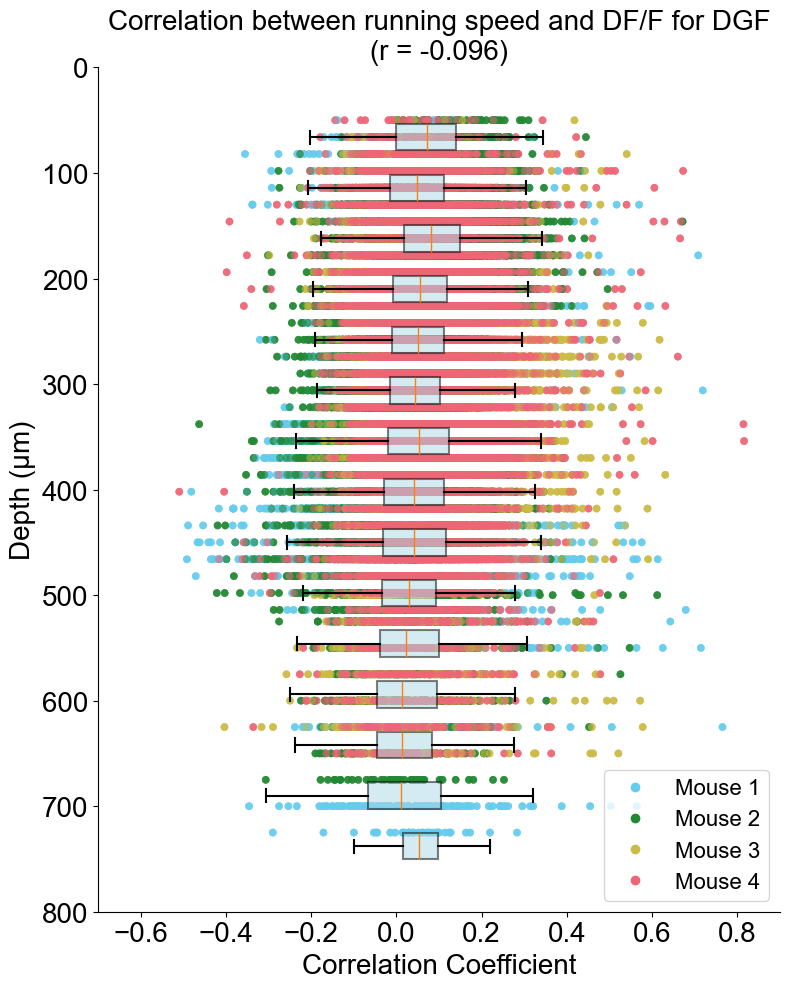

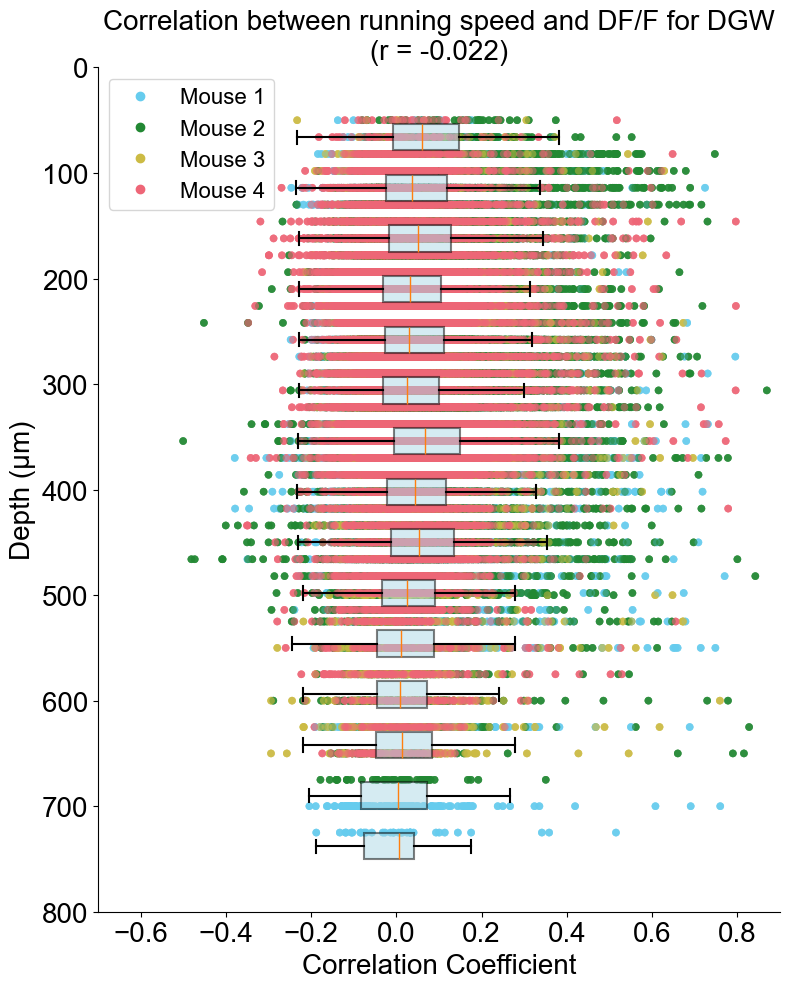

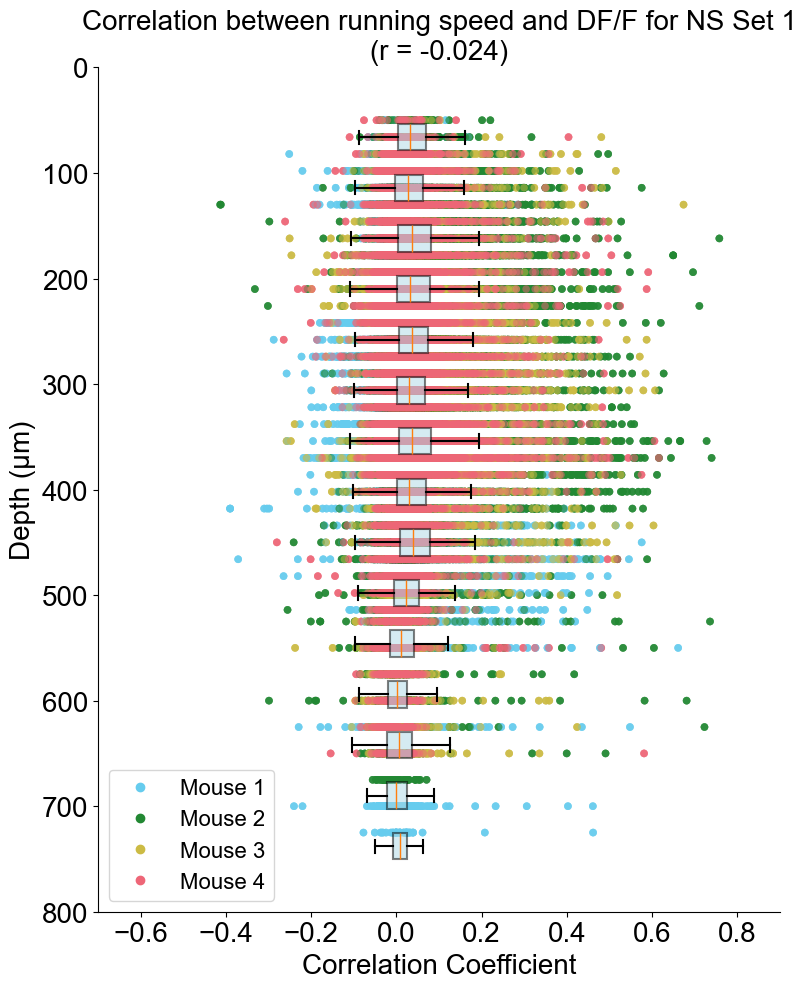

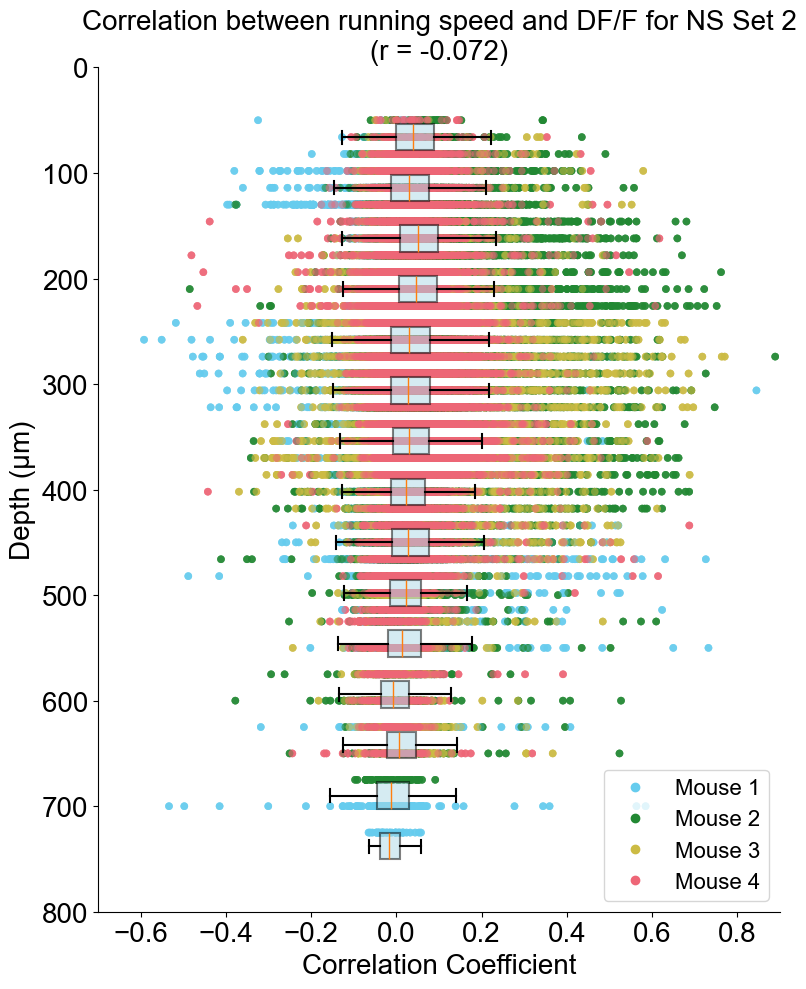

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

stim_types = ['run_corr_DGF', 'run_corr_DGW', 'run_corr_NI', 'run_corr_NI12']
stim_type_titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
mice_labels = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4']


for stim_ind, y_col in enumerate(stim_types):
    print(f"Processing stimulus type: {y_col}")

    x_col = 'depth'
    
    # Check if the required columns exist
    required_columns = [y_col, x_col, 'mouse_id']
    missing_columns = [col for col in required_columns if col not in running_df.columns]
    
    if missing_columns:
        print(f"Error: Missing columns in DataFrame: {missing_columns}")
    else:
        # Get unique mouse IDs
        mouse_ids = running_df['mouse_id'].unique()
        num_mice = len(mouse_ids)
        
        # Calculate grid dimensions for subplots
        # Try to make it as square as possible
        cols = math.ceil(math.sqrt(num_mice))
        rows = math.ceil(num_mice / cols)
        
        # Create a color palette for mouse_ids
        color_palette = ["#66CCEE", "#228833", "#CCBB44", "#EE6677"]
        
        # Create a dictionary mapping mouse_ids to colors and mice_labels
        mouse_colors = {mouse_id: color_palette[i] for i, mouse_id in enumerate(mouse_ids)}
        mouse_labels = {mouse_id: mice_labels[i] if i < len(mice_labels) else f"Mouse {mouse_id}" 
                        for i, mouse_id in enumerate(mouse_ids)}

        # Calculate correlation coefficient
        corr = running_df[y_col].corr(running_df[x_col])
        
        plt.figure(figsize=(8, 10))
        for mouse_id in mouse_ids:
            mouse_data = running_df[running_df['mouse_id'] == mouse_id]
            mouse_corr = mouse_data[y_col].corr(mouse_data[x_col])
            print(f"Correlation for {mouse_id} ({mouse_labels[mouse_id]}): {mouse_corr:.3f}")
                
            # Define custom color palette for mice
            custom_palette = color_palette
            
            # Create scatterplot
            sns.scatterplot(
                data=running_df,
                y=x_col,
                x=y_col,
                hue='mouse_id',
                alpha=0.5,
                s=30,
                palette=custom_palette,
                edgecolor='none', color=mouse_colors[mouse_id]
            )

        # Bin depths into 32 μm brackets starting from 50 μm
        bin_size = 48
        start_depth = 42
        end_depth = running_df[x_col].max()
        depth_bins = np.arange(start_depth, end_depth + bin_size, bin_size)
        depth_labels = [(f"{int(b)}–{int(b + bin_size)}") for b in depth_bins[:-1]]
        
        # Add binned depth column to DataFrame
        running_df['depth_bin'] = pd.cut(running_df[x_col], bins=depth_bins, labels=depth_labels, include_lowest=True)
        
        # Group by depth bin and collect data for boxplotting
        boxplot_data = []
        bin_centers = []
        
        for label in depth_labels:
            group = running_df[running_df['depth_bin'] == label][y_col]
            if not group.empty:
                boxplot_data.append(group.values)
                # Calculate center of the bin for plotting
                bin_range = label.split("–")
                center = (int(bin_range[0]) + int(bin_range[1])) / 2
                bin_centers.append(center)
        
        # Create boxplot at the bin centers
        bp = plt.boxplot(
            boxplot_data,
            positions=bin_centers,
            widths=25,
            patch_artist=True,
            vert=False,  # Horizontal boxplot
            zorder=9,
            showfliers=False
        )
        
        # Style the boxplot
        for box in bp['boxes']:
            box.set(color='black', linewidth=1.5, facecolor='lightblue', alpha=0.5)
        for whisker in bp['whiskers']:
            whisker.set(color='black', linewidth=1.5)
        for cap in bp['caps']:
            cap.set(color='black', linewidth=1.5)

        
        # Add title with correlation coefficient
        plt.title(
            f'Correlation between running speed and DF/F for {stim_type_titles[stim_ind]}\n(r = {corr:.3f})',
            fontsize=fontsize
        )        
        # And when creating the legend:
        plt.legend(handles=[plt.Line2D([0], [0], marker='o', color=color, label=mouse_labels[mouse_id], 
                   linestyle='') for mouse_id, color in mouse_colors.items()],
                   fontsize=fontsize-4)
    
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (μm)', fontsize=fontsize)
        plt.xlabel(f'Correlation Coefficient', fontsize=fontsize)
        
        # Determine the range of depths to set ticks at 100 μm increments
        min_depth = 0
        max_depth = 800
        depth_ticks = np.arange(min_depth, max_depth + 100, 100)
        
        # Set y-ticks at 100 μm increments with bold labels
        plt.yticks(depth_ticks, 
                   labels=[f'{int(d)}' for d in depth_ticks], 
                     fontsize=fontsize
            )
        plt.xlim([-0.7,.9])
        plt.xticks(fontsize=fontsize)
        plt.tight_layout()
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'SUPPFIG_running_depth_correlation_{y_col}{csv_tag}.png'), transparent=True, dpi=300)